# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
  1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
 -1.0
  1.0
  1.0
 -1.0

### We create a function to visualize the data

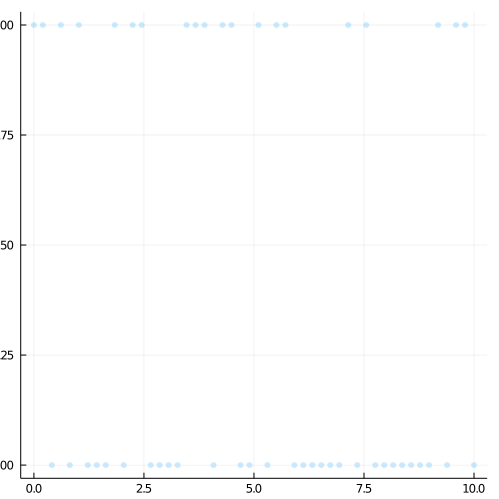

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

┌ Info: Running full model
└ @ Main.##475 string:1
  0.522623 seconds (1.14 M allocations: 66.360 MiB, 99.30% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

┌ Info: Sampling from model
└ @ Main.##475 string:1
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:33
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:48
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:52
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:24
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:07
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:55
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:47
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:27
Sampling with Gi

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.536170083090925, 0.7710708621037702, 0.951447532544062, 1.0192743154824522, 1.0120198750115563, 0.9118872746742108, 0.7659414825984336, 0.6217507335697929, 0.4761220429326296, 0.34237023883406226  …  -1.3408934723962935, -1.454932999486135, -1.6157274161655388, -1.630875897403567, -1.5630069262318182, -1.4221511938416223, -1.2270599977872116, -1.036343212598957, -0.8886984954773078, -0.8385577691350967]]
 [[0.4837922414528347, 0.18866051555821664, -0.15717074241903486, -0.5701703186098493, -0.9094039111829405, -1.162757554755808, -1.3003167905740958, -1.33348463155725, -1.29392449262662, -1.2276911044475283  …  -0.6956639622214604, -0.42614842573408496, -0.131072308443962, 0.1426292555937254, 0.4437383553234152, 0.6182762872627012, 0.6784889312629458, 0.6255043631922146, 0.4443711009922159, 0.1851728578485108]]
 [[0.11478294385539906, 0.022191003583331204, -0.05221137476491153, -0.053008992537686636, -0.02109525420750048, 0.00155515765

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

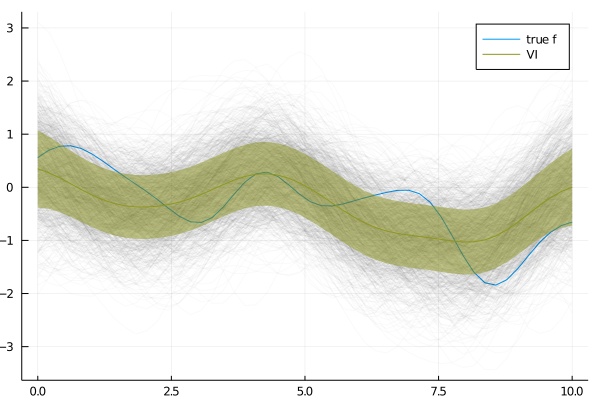

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

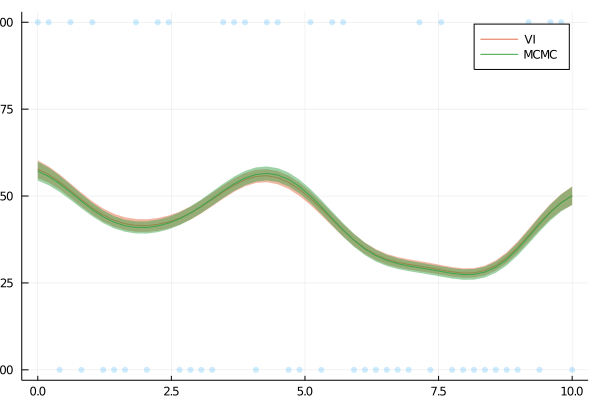

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*